Update February 12th 2019
--
We performed all classification experiments again the evoked response, but we selected components using a PCA with a target of 80 percent explained variance before training the classifiers. 

We train classifiers on one condition, and test it on the same or other condition (eg. Train Regular, Test Regular), so this is why we get four graphs. 

One interesting part would be to observe a group difference in the respect to which classifiers in one group are able to generalize across conditions, or not. 

For instance, one interesting hypothesis to test would be : 

- Classifiers trained on controls do generalize from the pattern trained in Regular when tested in Irregular, or the opposite. 
- Classifiers trained on Patients data are less/not able to generalize across conditions.


In [5]:
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline 
import os 
from statsmodels.stats import multitest

statspath = '/home/nfarrugi/datasets/mpi_pd_cueing/results_pca80perc//'

Step 0 - preparing data 

fields for the saved stats files are : 
- scores
- proba
- pval
- U

For each of them, layout is 4 (Regreg,RegIrreg,IrregReg,IrregIrreg) x CV x TestTime x TrainTime

Group files per subject type (patients or control) 

In [6]:
allsubj = os.listdir(statspath)

controls_id = []
patients_id = []

for cursubj in allsubj:
    if (cursubj[9]=='k'):
        controls_id.append(cursubj)
    else:
        if cursubj[10]=='1':
            patients_id.append(cursubj)
            

In [7]:
len(patients_id)

20

In [8]:
len(controls_id)

20

In [9]:
def diagonal_group(subjlist,statspath,thresh_unc = 0.01,timevec=None,showall=False,threshold_zeros=40,doplots=True,keepall=True,onlyregreg=False):


    if (showall):
        print("Showing all subjects")
    else:
        print("Showing subjects with less than %d FDR significant points" % threshold_zeros)
    
    diag_sig_fdr_all = []
    diag_sig_unc_all = []
    diag_ROC_all = []
    for subj in subjlist:
        cursubj = os.path.join(statspath,subj)
        curroc = np.load(cursubj)['scores'].mean(axis=1)
        curpvals = np.load(cursubj)['pval'].mean(axis=1) # Calculating mean p-value accross CV splits 
        diag_pvals = np.stack([np.diag(curmat) for curmat in curpvals]) # extract diagonal classification for each condition pair

        diag_ROC = np.stack([np.diag(curmat) for curmat in curroc]) # extract diagonal classification
        
        diag_sig_fdr = []
        diag_sig_unc = []
        
        if onlyregreg:
            H,p,_,_=multitest.multipletests(diag_pvals[2],method='fdr_bh')
            H_unc = diag_pvals[2] < thresh_unc
            diag_sig_unc.append(H_unc)
            diag_sig_fdr.append(H)        
        else:
            for curdiag in diag_pvals:
                H,p,_,_=multitest.multipletests(curdiag,method='fdr_bh')
                H_unc = curdiag < thresh_unc
                diag_sig_unc.append(H_unc)
                diag_sig_fdr.append(H)

        
        nonzeros = np.sum(np.stack(diag_sig_fdr))
        if showall:
            print("Subj %s number of non-zeros FDR : %d " %(subj,nonzeros))
                        
        elif nonzeros < threshold_zeros:
            print("Subj %s has zero or few significant FDR : %d " %(subj,nonzeros))
            
            if (nonzeros >= 0 ) and doplots:
                #plt.subplot(1,2,1)
                plt.plot(timevec,diag_sig_fdr[0])
                #plt.subplot(1,2,2)
                plt.plot(timevec,diag_ROC[0])
                plt.show()
            
        
        #print("Subj %s number of non-zeros Uncorrected : %d " %(subj,np.sum(np.stack(diag_sig_unc))))
        
        if (nonzeros > threshold_zeros) or keepall:
            diag_sig_fdr_all.append(np.stack(diag_sig_fdr))
            diag_sig_unc_all.append(np.stack(diag_sig_unc))
            diag_ROC_all.append(diag_ROC)

    
    return np.sum(np.stack(diag_sig_fdr_all),axis=0),np.sum(np.stack(diag_sig_unc_all),axis=0),np.stack(diag_ROC_all)

In [10]:
def plot_ROC_allcond(allscores,timepoints,figtitle='Default Title'):

    fig, (ax) = plt.subplots(ncols=2,nrows=2,figsize=(10,10))

    titles = ['Train Regular Test Regular',
              'Train Regular Test Irregular',
              'Train Irregular Test Regular',
              'Train Irregular Test Irregular']

    for i in range(4):
        curax = ax.ravel()[i]

        im = curax.matshow(allscores.mean(axis=1)[i], cmap='RdBu_r', vmin=0.2,vmax=0.8,origin='lower',
                            extent=timepoints)
        curax.axhline(0., color='k')
        curax.axvline(0., color='k')
        curax.xaxis.set_ticks_position('bottom')
        curax.set_xlabel('Testing Time (s)')
        curax.set_ylabel('Training Time (s)')
        curax.set_title(titles[i])
        plt.colorbar(im, ax=curax)
    fig.suptitle(figtitle)
    return fig

In [11]:
def plot_ROC_group(subjlist,statspath):

    diag_sig_fdr_all = []
    diag_sig_unc_all = []
    diag_ROC_all = []
    
    timepoints = np.array([-0.05      ,  0.52000002, -0.05      ,  0.52000002])
    for subj in subjlist:
        cursubj = os.path.join(statspath,subj)
        curroc = np.load(cursubj)['scores']
        curpvals = np.load(cursubj)['pval']
        #print(subj)
        
        plot_ROC_allcond(curroc,timepoints,subj)
        
        
        

Part1
--

Individual plots of ROC curves for temporal generalization using evoked resp + PCA80perc to train classifiers (averaged over four consecutive trials)
--

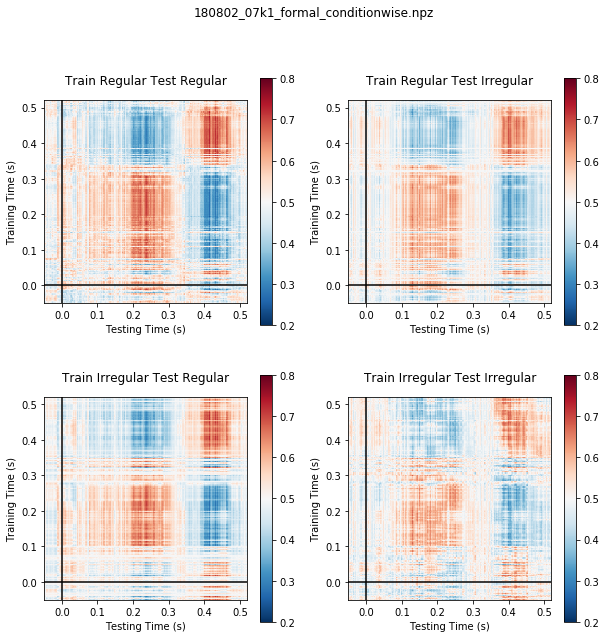

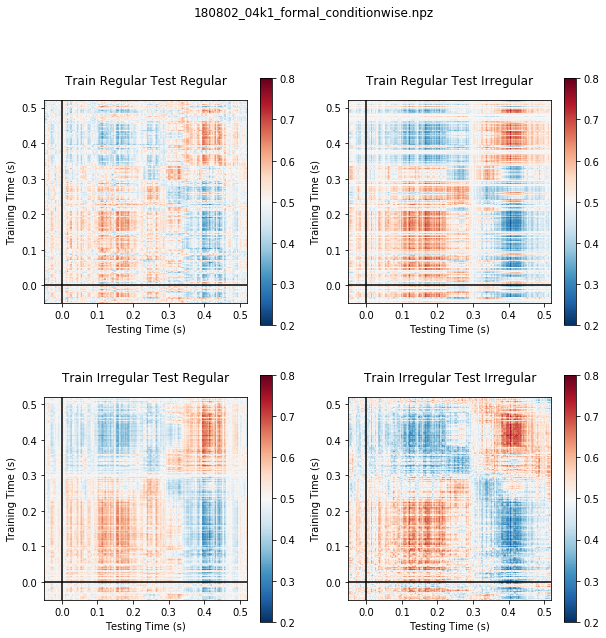

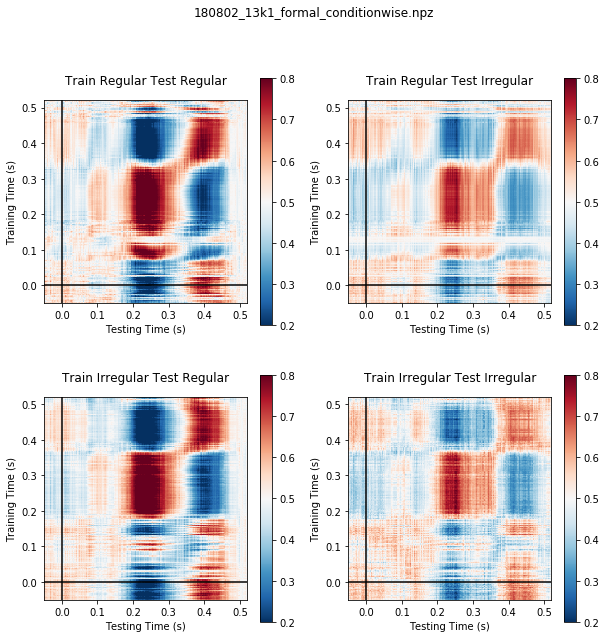

In [18]:
#plot_ROC_group(controls_id,statspath)
plot_ROC_group(controls_id[:3],statspath)

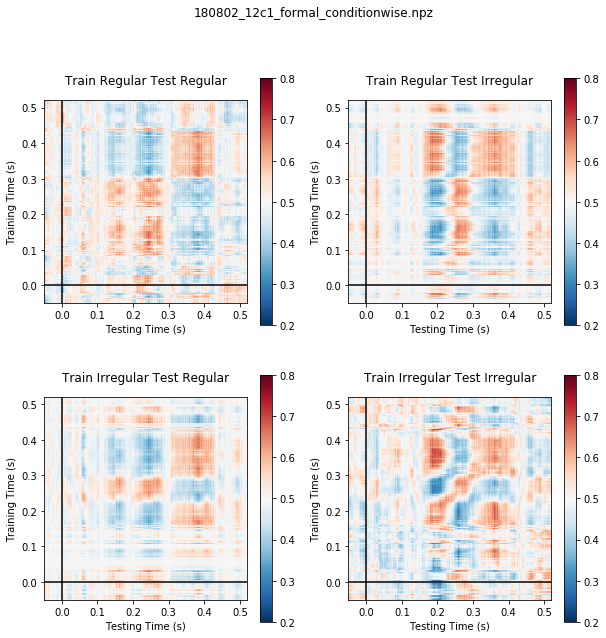

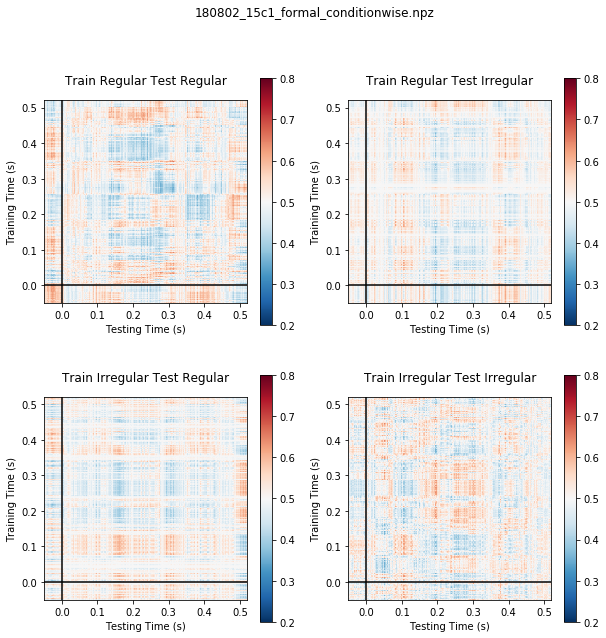

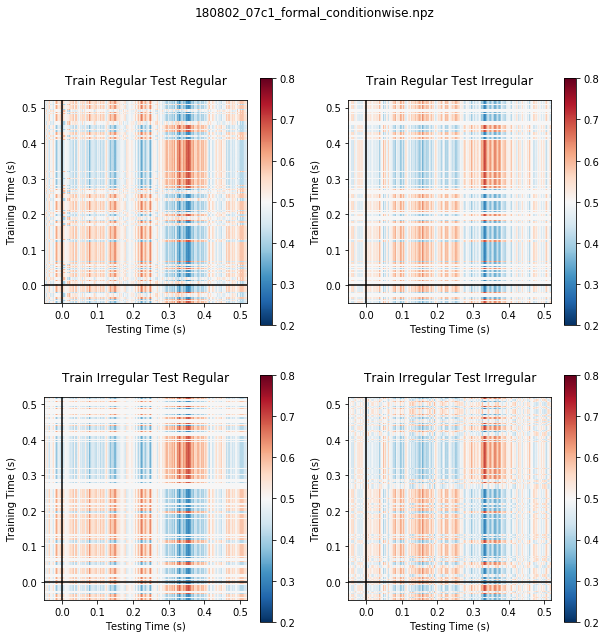

In [17]:
#plot_ROC_group(patients_id,statspath)
plot_ROC_group(patients_id[:3],statspath)

In [19]:
def four_plots(timevec,subtitles,diag_sig,mytitle):
    plt.figure(figsize=(10,10))

    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(timevec,diag_sig[i-1])
        plt.title(subtitles[i-1])
    plt.suptitle('Diagonal decoding - %s' % mytitle)
    plt.show()

In [20]:
def four_errorplots(timevec,subtitles,diag_roc,mytitle):
    plt.figure(figsize=(10,10))

    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.errorbar(timevec,diag_roc[:,i-1,:].mean(axis=0),yerr=diag_roc[:,i-1,:].std(axis=0),errorevery=5)
        plt.title(subtitles[i-1])
        plt.grid(True)
    plt.suptitle('Diagonal decoding - %s' % mytitle)
    plt.show()

Part2
--

Summarizing statistics using the beta results
--

Step 1 - Analysis of "Diagonal" Classification

We average the diagonal of the p values of the within-subjects Mann Whittney U-Test, and average them across CV folds. We correct the resulting p values using FDR Benjamin Hochberg correction, and sum the resulting vectors across all subjects. 

We also compute an uncorrected version with a threshold of $p < 0.01$

In [21]:
diag_sig_fdr_controls,diag_sig_unc_controls,diag_ROC_controls = diagonal_group(controls_id,statspath,0.05,doplots=False)
diag_sig_fdr_patients,diag_sig_unc_patients,diag_ROC_patients = diagonal_group(patients_id,statspath,0.05,doplots=False)

Showing subjects with less than 40 FDR significant points
Subj 180802_07k1_formal_conditionwise.npz has zero or few significant FDR : 18 
Subj 180802_04k1_formal_conditionwise.npz has zero or few significant FDR : 35 
Subj 180802_06k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_02k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_12k1_formal_conditionwise.npz has zero or few significant FDR : 21 
Subj 180802_11k1_formal_conditionwise.npz has zero or few significant FDR : 6 
Subj 180802_15k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_17k1_formal_conditionwise.npz has zero or few significant FDR : 39 
Subj 180802_16k1_formal_conditionwise.npz has zero or few significant FDR : 6 
Subj 180802_18k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Showing subjects with less than 40 FDR significant points
Subj 180802_12c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802

Most subjects don't have enough decodable information in "diagonal decoding" ! Which informally means that when training a classifier to discriminate between standard and deviants, at one specific time point (=thus "diagonal" decoding), the estimated probabilities of each trial being classified as either a standard or a deviant cannot be reliably distinguished (as shown by a lack of significance in a Mann-Whitney U-test).

One possible explanation : 
- after averaging, there are less trials available, so for some subjects it might prevent classification, while it wasn't an issue before averaging. 
- the time courses of the beta power are noisier than the evoked response (at the single trial level) 

Uncomment the following cell to output number of FDR corrected Mann Whitney whithin subjects statistics for all subjects (to give an idea how many signficant values we get for the ones who work well)

In [22]:
diag_sig_fdr_controls,diag_sig_unc_controls,_ = diagonal_group(controls_id,statspath,0.05,showall=True)
diag_sig_fdr_patients,diag_sig_unc_patients,_ = diagonal_group(patients_id,statspath,0.05,showall=True)

Showing all subjects
Subj 180802_07k1_formal_conditionwise.npz number of non-zeros FDR : 18 
Subj 180802_04k1_formal_conditionwise.npz number of non-zeros FDR : 35 
Subj 180802_13k1_formal_conditionwise.npz number of non-zeros FDR : 276 
Subj 180802_05k1_formal_conditionwise.npz number of non-zeros FDR : 121 
Subj 180802_06k1_formal_conditionwise.npz number of non-zeros FDR : 0 
Subj 180802_20k1_formal_conditionwise.npz number of non-zeros FDR : 209 
Subj 180802_09k1_formal_conditionwise.npz number of non-zeros FDR : 61 
Subj 180802_08k1_formal_conditionwise.npz number of non-zeros FDR : 144 
Subj 180802_02k1_formal_conditionwise.npz number of non-zeros FDR : 0 
Subj 180802_12k1_formal_conditionwise.npz number of non-zeros FDR : 21 
Subj 180802_11k1_formal_conditionwise.npz number of non-zeros FDR : 6 
Subj 180802_01k1_formal_conditionwise.npz number of non-zeros FDR : 414 
Subj 180802_14k1_formal_conditionwise.npz number of non-zeros FDR : 67 
Subj 180802_15k1_formal_conditionwise.npz

bottomline : PCA with 80 percent variance didn't boost SNR. It rather smoothed the maps, maybe boosted the SnR in subject with an already good SnR, but the ones with 0 were not helped. 

In [23]:
tmin = -0.05
tmax = 0.52

timevec = np.linspace(tmin,tmax,diag_sig_fdr_controls.shape[1])

In [24]:
subtitles = ['Train Regular Test Regular',
            'Train Regular Test Irregular',
            'Train Irregular Test Regular',
            'Train Irregular Test Irregular']

Uncomment the following cell to just plot the sum of significant Mann Wittney subjects as a function of time (FDR corrected) 

In [25]:
##four_plots(timevec,subtitles,diag_sig_fdr_controls,'Controls - FDR')

In [26]:
##four_plots(timevec,subtitles,diag_sig_fdr_patients,'Patients')

Uncomment the following lines to look at the same counts without FDR correction

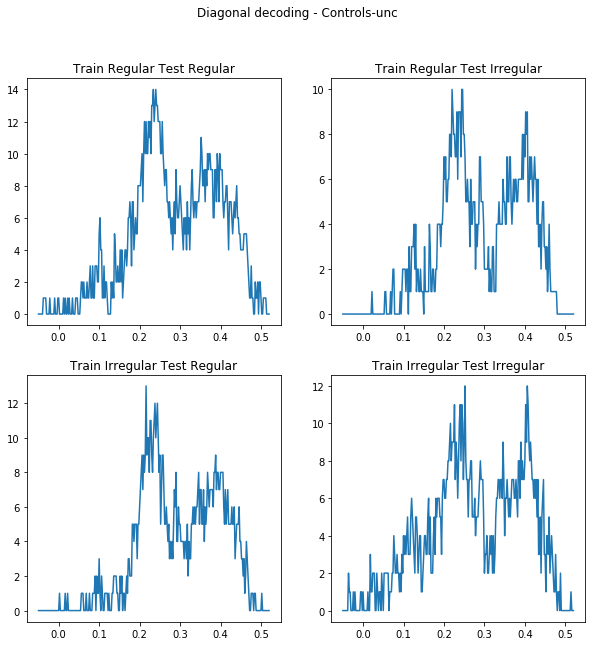

In [27]:
four_plots(timevec,subtitles,diag_sig_unc_controls,'Controls-unc')

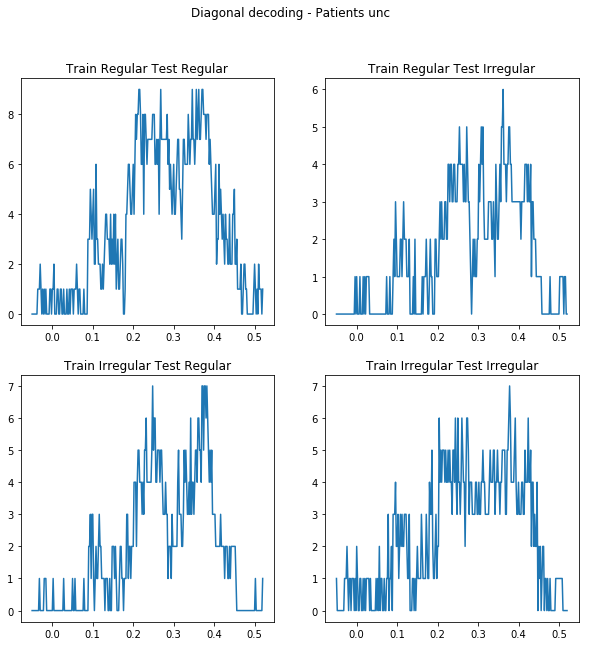

In [28]:
four_plots(timevec,subtitles,diag_sig_unc_patients,'Patients unc')


We can examine the ROC AUC scores for the same subjects, to check whether this phenomenon has anything to do with classification performance (it should!). For that, we overlay the FDR-corrected timewise significance of the Mann-Whitney U-test with the ROC AUC performance of the problematic subjects

In [158]:
#diag_sig_fdr_controls,diag_sig_unc_controls,diag_ROC_controls = diagonal_group(controls_id,statspath,0.05,timevec=timevec,doplots=True)
#diag_sig_fdr_patients,diag_sig_unc_patients,diag_ROC_patients = diagonal_group(patients_id,statspath,0.05,timevec=timevec,doplots=True)

To illustrate this at the group level, let's now plot the average and std of ROC AUC for the whole groups. 

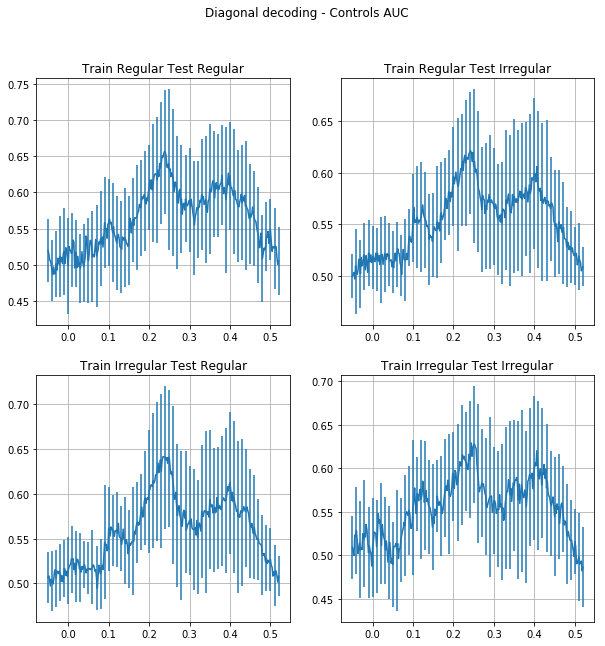

In [29]:
four_errorplots(timevec,subtitles,diag_roc=diag_ROC_controls,mytitle='Controls AUC')

For patients :

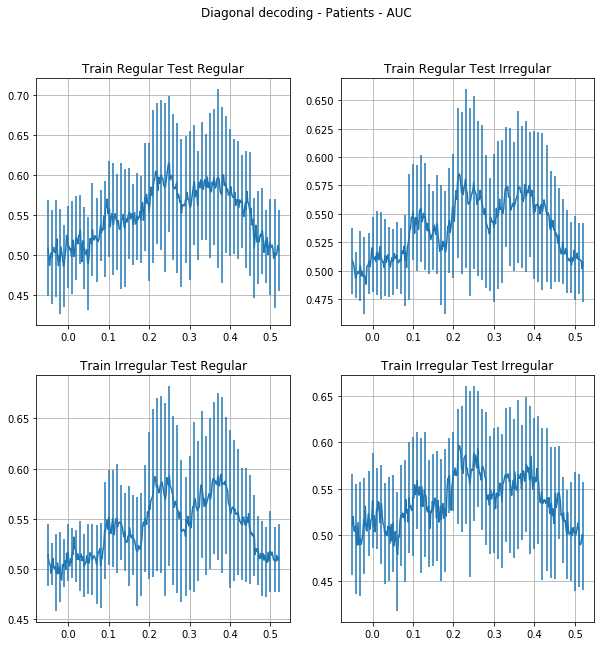

In [30]:
four_errorplots(timevec,subtitles,diag_roc=diag_ROC_patients,mytitle='Patients - AUC')

Let's have a look at the averages only, but superimposing patients and controls on the same plots, zooming in on the region 350ms to 500 ms. 

We will superimpose the result of an independent t-test at each time point, between groups

In [31]:
from scipy.stats import ttest_ind

def twogroups_fourplots(timevec,subtitles,diag_roc1,diag_roc2,mytitle,tstart=None,tend=None,ttest=False):
    plt.figure(figsize=(10,10))

    ngroup1 = diag_roc1.shape[0]
    ngroup2 = diag_roc2.shape[0]
    
    if tstart is None:
        tstart=0
    if tend is None:
        tend=timevec.shape[0]
    
    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(timevec[tstart:tend],diag_roc1[:,i-1,tstart:tend].mean(axis=0))
        plt.plot(timevec[tstart:tend],diag_roc2[:,i-1,tstart:tend].mean(axis=0))
        
        if ttest:
            
            
            tstat,p_unc = ttest_ind(a=diag_roc1[:,i-1,tstart:tend],b=diag_roc2[:,i-1,tstart:tend],equal_var=True)
            
            timevec_sub = timevec[tstart:tend]
            H = (p_unc<0.05)
            sig_ind = timevec_sub[H]
            sig= np.ones_like(sig_ind)*0.9
            
            #FDR correction            
            #H,p_fdr,_,_=multitest.multipletests(p_unc,method='fdr_bh')
            
            plt.plot(sig_ind,sig,'*')
            
            
        plt.title(subtitles[i-1])
        plt.grid(True)
    plt.legend(['controls (n=%d)' % ngroup1,'patients (n=%d)' % ngroup2,'ttest uncorr.'],loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.suptitle('Diagonal decoding - %s' % mytitle)
    plt.show()

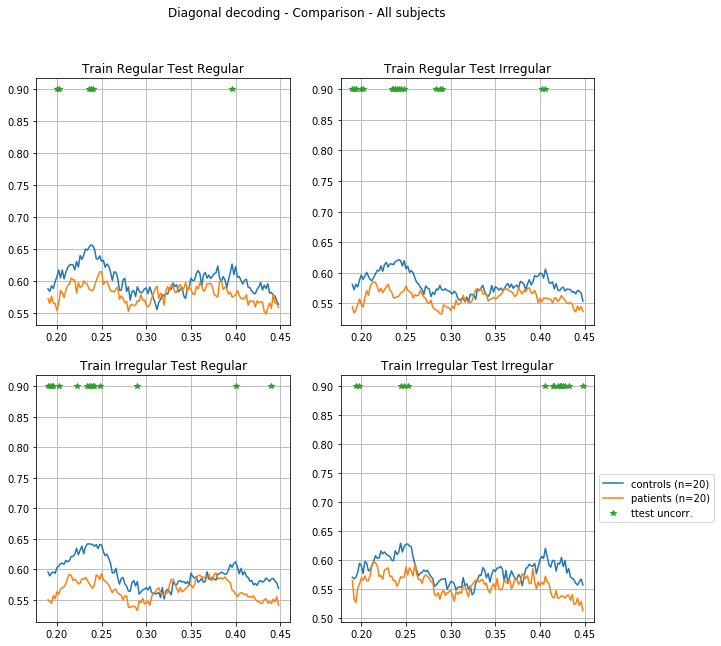

In [33]:
twogroups_fourplots(timevec,subtitles,diag_ROC_controls,diag_ROC_patients,'Comparison - All subjects',tstart=120,tend=250,ttest=True)

Part3
--

Evoked responses
--

High SNR subjects

Showing subjects with less than 40 FDR significant points
Subj 180802_07k1_formal_conditionwise.npz has zero or few significant FDR : 18 
Subj 180802_04k1_formal_conditionwise.npz has zero or few significant FDR : 35 
Subj 180802_06k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_02k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_12k1_formal_conditionwise.npz has zero or few significant FDR : 21 
Subj 180802_11k1_formal_conditionwise.npz has zero or few significant FDR : 6 
Subj 180802_15k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_17k1_formal_conditionwise.npz has zero or few significant FDR : 39 
Subj 180802_16k1_formal_conditionwise.npz has zero or few significant FDR : 6 
Subj 180802_18k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Showing subjects with less than 40 FDR significant points
Subj 180802_12c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802

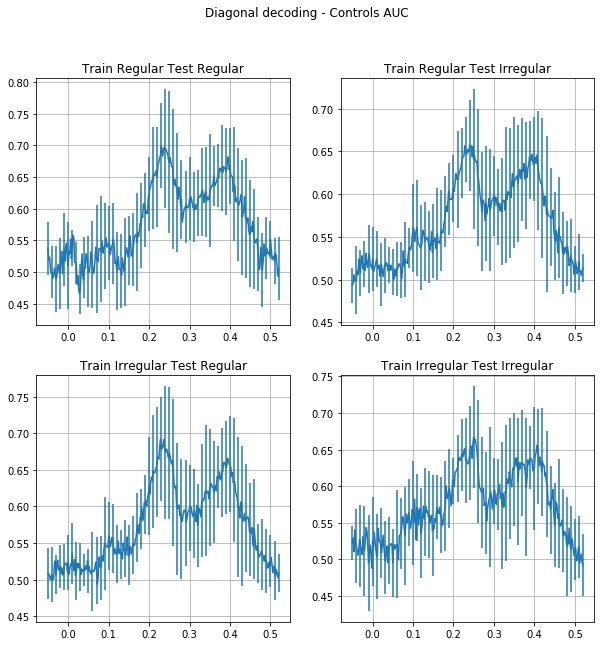

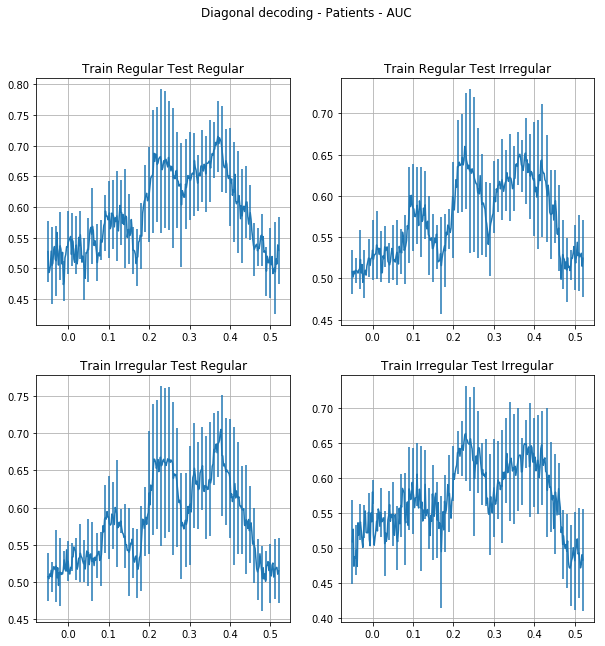

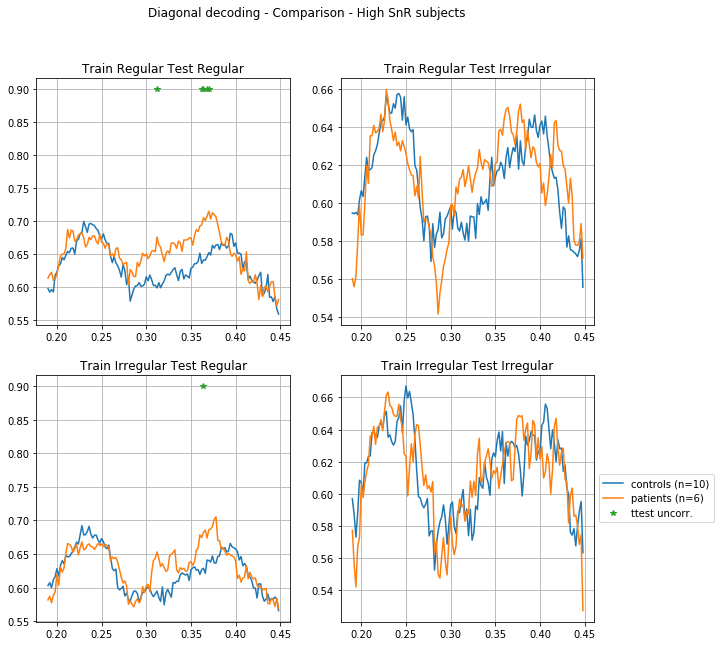

In [39]:
diag_sig_fdr_controls,diag_sig_unc_controls,diag_ROC_controls = diagonal_group(controls_id,statspath,0.05,doplots=False,keepall=False)
diag_sig_fdr_patients,diag_sig_unc_patients,diag_ROC_patients = diagonal_group(patients_id,statspath,0.05,doplots=False,keepall=False)

four_errorplots(timevec,subtitles,diag_roc=diag_ROC_controls,mytitle='Controls AUC')
four_errorplots(timevec,subtitles,diag_roc=diag_ROC_patients,mytitle='Patients - AUC')

twogroups_fourplots(timevec,subtitles,diag_ROC_controls,diag_ROC_patients,'Comparison - High SnR subjects',tstart=120,tend=250,ttest=True)

Showing subjects with less than 40 FDR significant points
Subj 180802_07k1_formal_conditionwise.npz has zero or few significant FDR : 18 
Subj 180802_04k1_formal_conditionwise.npz has zero or few significant FDR : 35 
Subj 180802_06k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_02k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_12k1_formal_conditionwise.npz has zero or few significant FDR : 21 
Subj 180802_11k1_formal_conditionwise.npz has zero or few significant FDR : 6 
Subj 180802_15k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_17k1_formal_conditionwise.npz has zero or few significant FDR : 39 
Subj 180802_16k1_formal_conditionwise.npz has zero or few significant FDR : 6 
Subj 180802_18k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Showing subjects with less than 40 FDR significant points
Subj 180802_12c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802

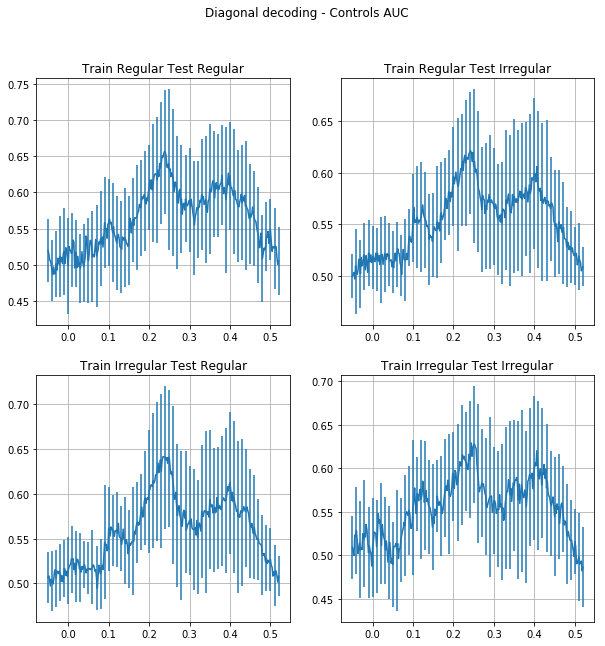

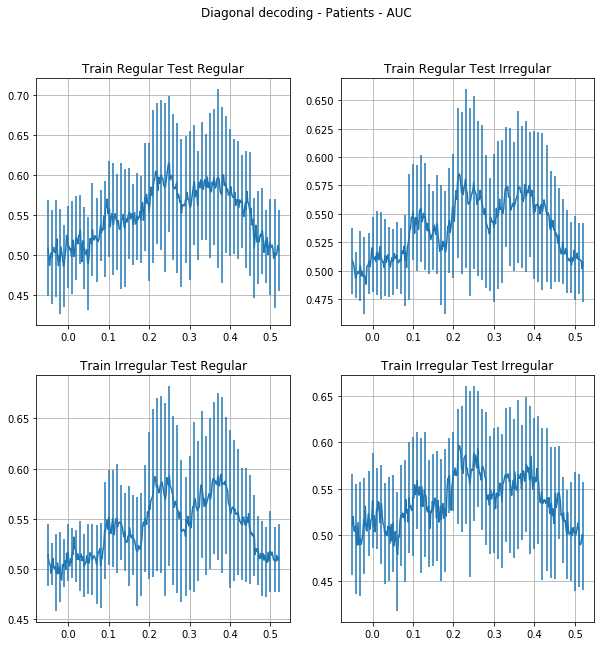

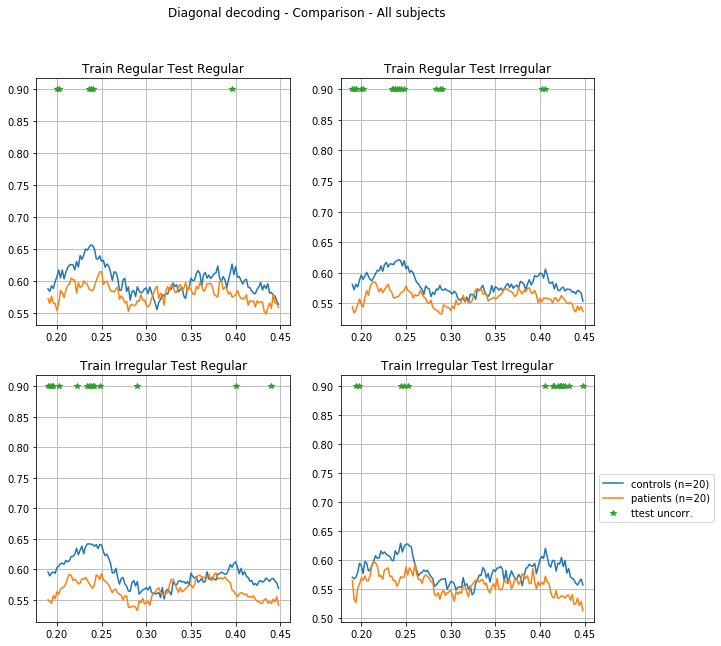

In [40]:
diag_sig_fdr_controls,diag_sig_unc_controls,diag_ROC_controls = diagonal_group(controls_id,statspath,0.05,doplots=False,keepall=True)
diag_sig_fdr_patients,diag_sig_unc_patients,diag_ROC_patients = diagonal_group(patients_id,statspath,0.05,doplots=False,keepall=True)

four_errorplots(timevec,subtitles,diag_roc=diag_ROC_controls,mytitle='Controls AUC')
four_errorplots(timevec,subtitles,diag_roc=diag_ROC_patients,mytitle='Patients - AUC')

twogroups_fourplots(timevec,subtitles,diag_ROC_controls,diag_ROC_patients,'Comparison - All subjects',tstart=120,tend=250,ttest=True)

Part4
--

Next steps ? 
--

- feature selection suing kbest